In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json
from os.path import expanduser
import sqlite3
import seaborn as sns
import random
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches
import glob

### detections

In [4]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

FEATURES_PASEF_DIR = '{}/features-pasef'.format(EXPERIMENT_DIR)
FEATURES_PASEF_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_PASEF_DIR, experiment_name, run_name)

minvi = 4000
FEATURES_3DID_DIR = sorted(glob.glob('/media/big-ssd/results-P3856-3did/minvi-{}-*/features-3did'.format(minvi)))[-1]
FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

FEATURES_MQ_DIR = '{}/features-mq'.format(EXPERIMENT_DIR)
FEATURES_MQ_FILE = '{}/exp-{}-run-{}-features-mq-dedup.pkl'.format(FEATURES_MQ_DIR, experiment_name, run_name)

In [5]:
MAXIMUM_Q_VALUE = 0.01

In [6]:
CONVERTED_DATABASE_NAME = "{}/converted-databases/exp-{}-run-{}-converted.sqlite".format(EXPERIMENT_DIR, experiment_name, run_name)

In [7]:
# only look at this part of the run
RT_LOWER = 1650
RT_UPPER = 2200

In [8]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

#### PASEF-seeded

In [9]:
# load the features detected by PASEF
with open(FEATURES_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_pasef_df = d['features_df']

In [10]:
features_pasef_df['excluded'] = features_pasef_df.apply(lambda row: row.scan_lower < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_pasef_df = features_pasef_df[(features_pasef_df.excluded == False)]
features_pasef_df = features_pasef_df[(features_pasef_df.rt_lower >= RT_LOWER) & (features_pasef_df.rt_upper <= RT_UPPER)]

#### 3DID

In [11]:
# load the features detected by 3DID
with open(FEATURES_3DID_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_df']

#### MaxQuant

In [12]:
# load the features detected by MaxQuant
with open(FEATURES_MQ_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_mq_df = d['features_df']

In [13]:
features_mq_df.sample(n=5)

,feature_id,monoisotopic_mass,charge,monoisotopic_mz,intensity,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,raw_file,envelope,isotope_count,mq_index,ms2_peaks
4560,1185583,1461.6934,2,731.85397,5746,573,562.5,583.5,1692.0,1691.472,1692.528,P3856_YHE211_1_Slot1-1_1_5104,"[[731.85397, 0.0], [732.8573250000001, 0.0]]",2,4560,"[{'mz': 199.18239, 'intensity': 9}, {'mz': 205..."
4010,1183235,1432.6454,2,717.32995,44354,624,610.5,637.5,1728.0,1726.146,1729.854,P3856_YHE211_1_Slot1-1_1_5104,"[[717.32995, 0.0], [719.33666, 0.0]]",4,4010,"[{'mz': 216.10041, 'intensity': 14}, {'mz': 21..."
4601,1185776,1464.6647,2,733.33964,304290,579,552.0,606.0,1632.0,1630.941,1633.059,P3856_YHE211_1_Slot1-1_1_5104,"[[733.33964, 0.0], [735.8480275000001, 0.0]]",5,4601,"[{'mz': 199.10936, 'intensity': 10}, {'mz': 20..."
8056,1195118,1635.7949,2,818.90472,72400,489,468.0,510.0,1812.0,1808.820,1815.180,P3856_YHE211_1_Slot1-1_1_5104,"[[818.90472, 0.0], [820.4097525, 0.0]]",3,8056,"[{'mz': 199.07395, 'intensity': 10}, {'mz': 20..."
16154,1215119,2000.0470,2,1001.03080,40164,273,255.0,291.0,2088.0,2084.550,2091.450,P3856_YHE211_1_Slot1-1_1_5104,"[[1001.0308, 0.0], [1002.5358325, 0.0]]",3,16154,"[{'mz': 213.16645, 'intensity': 13}, {'mz': 27..."


In [14]:
features_mq_df['excluded'] = features_mq_df.apply(lambda row: row.scan_lower < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_mq_df = features_mq_df[(features_mq_df.excluded == False)]
features_mq_df = features_mq_df[(features_mq_df.rt_lower >= RT_LOWER) & (features_mq_df.rt_upper <= RT_UPPER)]
features_mq_df = features_mq_df[(features_mq_df.isotope_count >= 3)]

In [15]:
print('{} features from PASEF, {} features from MaxQuant, {} features from 3DID'.format(len(features_pasef_df), len(features_mq_df), len(features_3did_df)))


69742 features from PASEF, 15044 features from MaxQuant, 40357 features from 3DID


#### consolidate the features from all methods

In [16]:
combined_names = ['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']

In [17]:
combined_features_mq_df = features_mq_df[combined_names].copy()
combined_features_mq_df['method'] = 'mq'

combined_features_pasef_df = features_pasef_df[combined_names].copy()
combined_features_pasef_df['method'] = 'pasef'

combined_features_3did_df = features_3did_df[combined_names].copy()
combined_features_3did_df['method'] = '3did'

combined_features_df = pd.concat([combined_features_mq_df,combined_features_pasef_df,combined_features_3did_df], axis=0, sort=False, ignore_index=True)
combined_features_df['method_feature_id'] = combined_features_df.method+'-'+combined_features_df.feature_id.astype('str')

#### find the features in common

In [18]:
DUP_MZ_TOLERANCE_PPM = 10
DUP_SCAN_TOLERANCE = 20
DUP_RT_TOLERANCE = 5

In [19]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
combined_features_df['dup_mz'] = combined_features_df['monoisotopic_mz']  # shorthand to reduce verbosity
combined_features_df['dup_mz_ppm_tolerance'] = combined_features_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
combined_features_df['dup_mz_lower'] = combined_features_df.dup_mz - combined_features_df.dup_mz_ppm_tolerance
combined_features_df['dup_mz_upper'] = combined_features_df.dup_mz + combined_features_df.dup_mz_ppm_tolerance
combined_features_df['dup_scan_lower'] = combined_features_df.scan_apex - DUP_SCAN_TOLERANCE
combined_features_df['dup_scan_upper'] = combined_features_df.scan_apex + DUP_SCAN_TOLERANCE
combined_features_df['dup_rt_lower'] = combined_features_df.rt_apex - DUP_RT_TOLERANCE
combined_features_df['dup_rt_upper'] = combined_features_df.rt_apex + DUP_RT_TOLERANCE

In [20]:
combined_id = 1
sets_d = {'mq':set(), '3did':set(), 'pasef':set()}
features_processed = set()
for row in combined_features_df.itertuples():
    if row.method_feature_id not in features_processed:
        df = combined_features_df[(row.charge == combined_features_df.charge) & (row.dup_mz >= combined_features_df.dup_mz_lower) & (row.dup_mz <= combined_features_df.dup_mz_upper) & (row.scan_apex >= combined_features_df.dup_scan_lower) & (row.scan_apex <= combined_features_df.dup_scan_upper) & (row.rt_apex >= combined_features_df.dup_rt_lower) & (row.rt_apex <= combined_features_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.method_feature_id.tolist()) - features_processed
            df = df[(df.method_feature_id.isin(feature_ids_not_processed))]
            for method in df.method.tolist():
                sets_d[method].add(combined_id)
            # record the features that have been processed
            features_processed.update(set(df.method_feature_id.tolist()))
            combined_id += 1

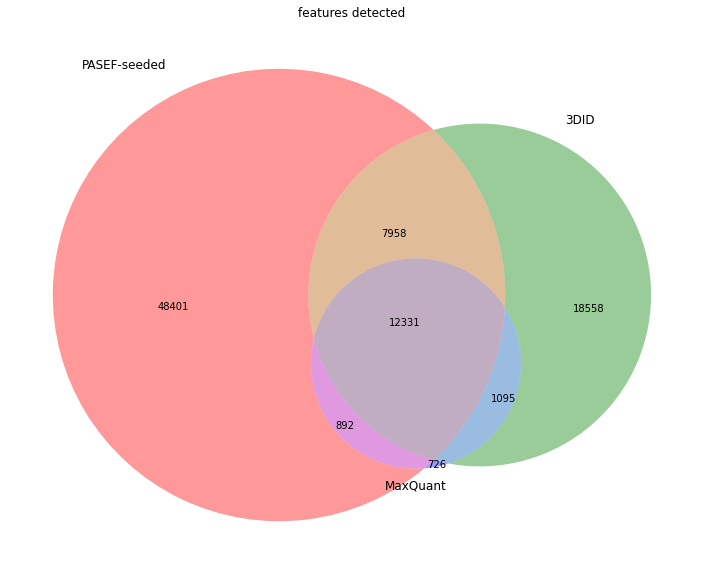

In [21]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features detected')

venn3([sets_d['pasef'],sets_d['3did'],sets_d['mq']], ('PASEF-seeded','3DID','MaxQuant'))

plt.show()

### identifications

#### PASEF-seeded

In [22]:
IDENTS_PASEF_DIR = '{}/identifications-pasef'.format(EXPERIMENT_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

In [23]:
# load the features identified by PASEF
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_pasef_df = d['identifications_df']
idents_pasef_df = idents_pasef_df[(idents_pasef_df.run_name == run_name) & (idents_pasef_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()

In [24]:
idents_pasef_df['excluded'] = idents_pasef_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_pasef_df = idents_pasef_df[(idents_pasef_df.excluded == False)]

In [25]:
idents_pasef_df.to_pickle('{}/idents_pasef_df.pkl'.format(expanduser('~')))

#### MaxQuant

In [26]:
MQ_PERCOLATOR_OUTPUT_DIR = '{}/percolator-output-pasef-maxquant'.format(EXPERIMENT_DIR)

In [27]:
# load the percolator output
MQ_PERCOLATOR_OUTPUT_FILE_NAME = "{}/{}.percolator.target.psms.txt".format(MQ_PERCOLATOR_OUTPUT_DIR, experiment_name)
mq_psms_df = pd.read_csv(MQ_PERCOLATOR_OUTPUT_FILE_NAME, sep='\t')
mq_psms_df.rename(columns={'scan': 'mq_index'}, inplace=True)
mq_psms_df.drop(['charge'], axis=1, inplace=True)
# remove the poor quality identifications
mq_psms_df = mq_psms_df[mq_psms_df['peptide mass'] > 0]

In [28]:
idents_mq_df = pd.merge(features_mq_df, mq_psms_df, how='left', left_on=['mq_index'], right_on=['mq_index'])
# remove any features that were not identified
idents_mq_df.dropna(subset=['sequence'], inplace=True)

In [29]:
idents_mq_df = idents_mq_df[(idents_mq_df.raw_file == run_name) & (idents_mq_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()

In [30]:
idents_mq_df['excluded'] = idents_mq_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_mq_df = idents_mq_df[(idents_mq_df.excluded == False)]
idents_mq_df = idents_mq_df[(idents_mq_df.rt_apex >= RT_LOWER) & (idents_mq_df.rt_apex <= RT_UPPER)]
idents_mq_df['feature_intensity'] = idents_mq_df.intensity
idents_mq_df = idents_mq_df[(idents_mq_df.isotope_count >= 3)].copy()

In [31]:
idents_mq_df.to_pickle('{}/idents_mq_df.pkl'.format(expanduser('~')))

#### consolidate the identifications from all methods

In [32]:
combined_names = ['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']

In [33]:
combined_idents_mq_df = idents_mq_df[combined_names].copy()
combined_idents_mq_df['method'] = 'mq'

combined_idents_pasef_df = idents_pasef_df[combined_names].copy()
combined_idents_pasef_df['method'] = 'pasef'

combined_idents_3did_df = features_3did_df[combined_names].copy()
combined_idents_3did_df['method'] = '3did'

combined_idents_df = pd.concat([combined_idents_mq_df,combined_idents_pasef_df,combined_idents_3did_df], axis=0, sort=False, ignore_index=True)
combined_idents_df['method_feature_id'] = combined_idents_df.method+'-'+combined_idents_df.feature_id.astype('str')

#### find the identifications in common

In [34]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
combined_idents_df['dup_mz'] = combined_idents_df['monoisotopic_mz']  # shorthand to reduce verbosity
combined_idents_df['dup_mz_ppm_tolerance'] = combined_idents_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
combined_idents_df['dup_mz_lower'] = combined_idents_df.dup_mz - combined_idents_df.dup_mz_ppm_tolerance
combined_idents_df['dup_mz_upper'] = combined_idents_df.dup_mz + combined_idents_df.dup_mz_ppm_tolerance
combined_idents_df['dup_scan_lower'] = combined_idents_df.scan_apex - DUP_SCAN_TOLERANCE
combined_idents_df['dup_scan_upper'] = combined_idents_df.scan_apex + DUP_SCAN_TOLERANCE
combined_idents_df['dup_rt_lower'] = combined_idents_df.rt_apex - DUP_RT_TOLERANCE
combined_idents_df['dup_rt_upper'] = combined_idents_df.rt_apex + DUP_RT_TOLERANCE

In [35]:
combined_id = 1
combined_features = []
sets_d = {'mq':set(), '3did':set(), 'pasef':set()}
features_processed = set()
for row in combined_idents_df.itertuples():
    if row.method_feature_id not in features_processed:
        df = combined_idents_df[(row.charge == combined_idents_df.charge) & (row.dup_mz >= combined_idents_df.dup_mz_lower) & (row.dup_mz <= combined_idents_df.dup_mz_upper) & (row.scan_apex >= combined_idents_df.dup_scan_lower) & (row.scan_apex <= combined_idents_df.dup_scan_upper) & (row.rt_apex >= combined_idents_df.dup_rt_lower) & (row.rt_apex <= combined_idents_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.method_feature_id.tolist()) - features_processed
            df = df[(df.method_feature_id.isin(feature_ids_not_processed))]
            for method in df.method.tolist():
                sets_d[method].add(combined_id)
            # record the features that have been processed
            features_processed.update(set(df.method_feature_id.tolist()))
            # separate the method feature ids
            feature_ids = {'3did':0, 'pasef':0, 'mq':0}
            for m in df.method_feature_id.tolist():
                method = m.split('-')[0]
                feature_id = int(m.split('-')[1])
                feature_ids[method] = feature_id
            # store the features that were combined
            combined_features.append({'combined_id':combined_id, 'number_of_methods':len(df.method.unique()), 'methods':list(df.method.unique()), 'method_ids':df.method_feature_id.tolist(), '3did_feature_id':feature_ids['3did'], 'pasef_feature_id':feature_ids['pasef'], 'mq_feature_id':feature_ids['mq']})
            # update the combined feature identifier
            combined_id += 1

In [36]:
combined_features_df = pd.DataFrame(combined_features)

In [37]:
combined_features_df.sample(n=5)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id
15786,15787,1,[3did],[3did-42022],42022,0,0
17176,17177,1,[3did],[3did-75504],75504,0,0
38443,38444,1,[3did],[3did-54669],54669,0,0
32474,32475,1,[3did],[3did-29600],29600,0,0
13246,13247,1,[3did],[3did-2409],2409,0,0


In [38]:
# merge 3DID attributes
combined_features_df = pd.merge(combined_features_df, features_3did_df[['feature_id','prediction','deconvolution_score','feature_intensity']], how='left', left_on=['3did_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'prediction':'3did_prediction', 'deconvolution_score':'3did_deconvolution_score', 'feature_intensity':'3did_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [39]:
# merge PASEF attributes
combined_features_df = pd.merge(combined_features_df, idents_pasef_df[['feature_id','deconvolution_score','feature_intensity']], how='left', left_on=['pasef_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'deconvolution_score':'pasef_deconvolution_score', 'feature_intensity':'pasef_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [40]:
# merge MQ attributes
combined_features_df = pd.merge(combined_features_df, idents_mq_df[['feature_id','feature_intensity']], how='left', left_on=['mq_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'feature_intensity':'mq_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [41]:
combined_features_df['3did_log_intensity'] = np.log10(combined_features_df['3did_feature_intensity'])
combined_features_df['pasef_log_intensity'] = np.log10(combined_features_df.pasef_feature_intensity)
combined_features_df['mq_log_intensity'] = np.log10(combined_features_df.mq_feature_intensity)

In [42]:
combined_features_df.fillna(0, inplace=True)

In [43]:
combined_features_df.to_pickle('{}/combined_idents_df.pkl'.format(expanduser('~')))

In [44]:
combined_features_df.sample(n=3)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id,3did_prediction,3did_deconvolution_score,3did_feature_intensity,pasef_deconvolution_score,pasef_feature_intensity,mq_feature_intensity,3did_log_intensity,pasef_log_intensity,mq_log_intensity
35528,35529,1,[3did],[3did-61045],61045,0,0,0.691269,265.182556,2436,0.000000,0.0,0.0,3.386677,0.000000,0.000000
1150,1151,3,"[mq, pasef, 3did]","[mq-1188789, pasef-4056401, 3did-19114]",19114,4056401,1188789,0.835459,696.672974,4808,533.870119,4808.0,75310.0,3.681964,3.681964,4.876853
35776,35777,1,[3did],[3did-48529],48529,0,0,0.685552,291.859650,1546,0.000000,0.0,0.0,3.189209,0.000000,0.000000


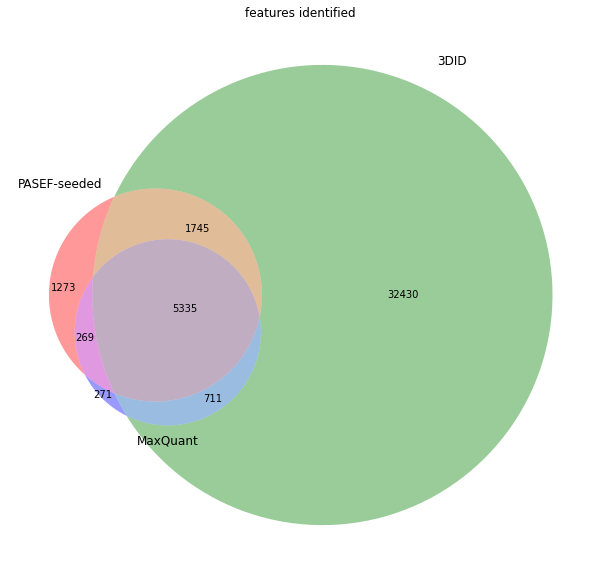

In [45]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features identified')

venn3([sets_d['pasef'],sets_d['3did'],sets_d['mq']], ('PASEF-seeded','3DID','MaxQuant'))

plt.show()

### analyse features that were only identified by the PASEF-seeded method

In [46]:
combined_id_pasef_only = sets_d['pasef']-sets_d['mq']-sets_d['3did']

In [47]:
combined_features_df[(combined_features_df.combined_id.isin(combined_id_pasef_only))].sort_values(by=['pasef_feature_intensity'], ascending=False, inplace=False).head(n=3)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id,3did_prediction,3did_deconvolution_score,3did_feature_intensity,pasef_deconvolution_score,pasef_feature_intensity,mq_feature_intensity,3did_log_intensity,pasef_log_intensity,mq_log_intensity
7324,7325,1,[pasef],[pasef-3893001],0,3893001,0,0.790378,246.38414,2723,510.085384,94354.0,0.0,3.435048,4.974760,0.0
6744,6745,1,[pasef],[pasef-2272901],0,2272901,0,0.790378,246.38414,2723,871.705628,81368.0,0.0,3.435048,4.910454,0.0
6852,6853,1,[pasef],[pasef-4030601],0,4030601,0,0.790378,246.38414,2723,718.467985,79650.0,0.0,3.435048,4.901186,0.0


In [48]:
pasef_feature = features_pasef_df[(features_pasef_df.feature_id == 3893001)].iloc[0]
pasef_feature

mono_mz_lower                                                                    1094.999828
mono_mz_upper                                                                    1095.069581
scan_apex                                                                               95.0
scan_lower                                                                                60
scan_upper                                                                               133
rt_apex                                                                          2114.067227
rt_lower                                                                         2111.420824
rt_upper                                                                         2117.242239
intensity_without_saturation_correction                                                61065
intensity_with_saturation_correction                                                   94354
mono_intensity_adjustment_outcome                            monoisoto

In [49]:
rt_df = pd.DataFrame(pasef_feature.rt_df)

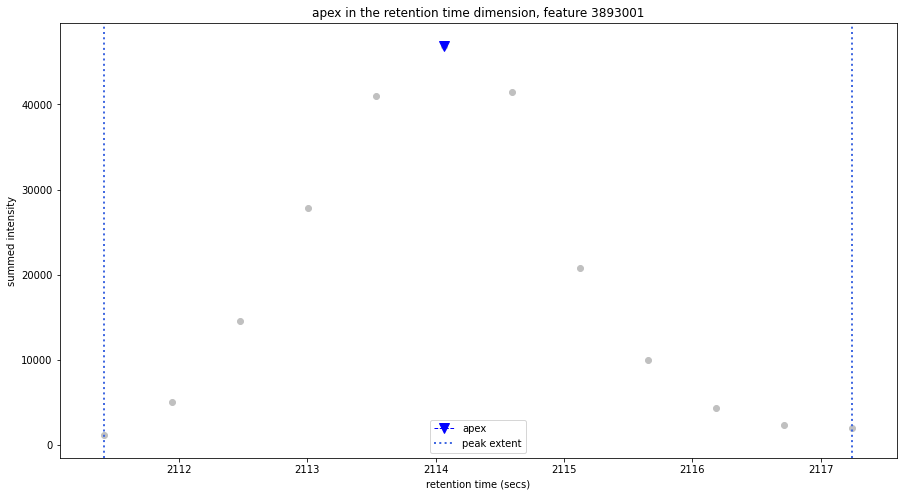

In [50]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver')

plt.plot(pasef_feature.rt_apex, rt_df[rt_df.retention_time_secs==pasef_feature.rt_apex].intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=pasef_feature.rt_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=pasef_feature.rt_upper, linestyle=':', color='royalblue', linewidth=2)

plt.title('apex in the retention time dimension, feature {}'.format(pasef_feature.feature_id))
plt.legend()
plt.xlabel("retention time (secs)")
plt.ylabel("summed intensity")
plt.show()

#### isotope extent in mobility

In [51]:
scan_df = pd.DataFrame(pasef_feature.scan_df)

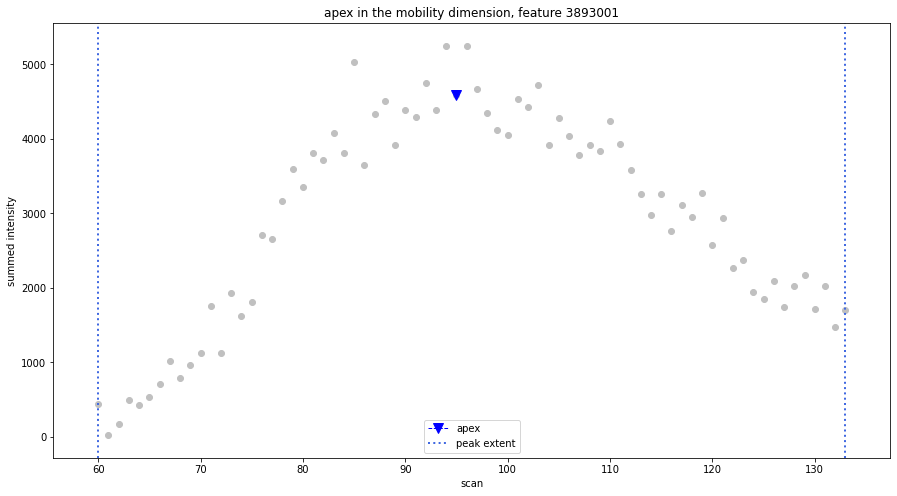

In [52]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_df.scan, scan_df.intensity, c='silver')

plt.plot(pasef_feature.scan_apex, scan_df[scan_df.scan==pasef_feature.scan_apex].intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=pasef_feature.scan_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=pasef_feature.scan_upper, linestyle=':', color='royalblue', linewidth=2)

plt.title('apex in the mobility dimension, feature {}'.format(pasef_feature.feature_id))
plt.legend()
plt.xlabel("scan")
plt.ylabel("summed intensity")
plt.show()

#### feature region at its RT apex

In [53]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)

In [54]:
feature_mz_lower = json.loads(pasef_feature.envelope)[0][0]
feature_mz_upper = json.loads(pasef_feature.envelope)[-1][0]
feature_scan_lower = pasef_feature.scan_lower
feature_scan_upper = pasef_feature.scan_upper
feature_rt_lower = pasef_feature.rt_apex - 1
feature_rt_upper = pasef_feature.rt_apex + 1

In [55]:
mz_lower = feature_mz_lower - 1
mz_upper = feature_mz_upper + 1
scan_lower = feature_scan_lower - 20
scan_upper = feature_scan_upper + 20
rt_lower = feature_rt_lower
rt_upper = feature_rt_upper

In [56]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type == 0 and retention_time_secs >= {} and retention_time_secs <= {} and scan >= {} and scan <= {} and mz >= {} and mz <= {}".format(rt_lower, rt_upper, scan_lower, scan_upper, mz_lower, mz_upper), db_conn)
db_conn.close()

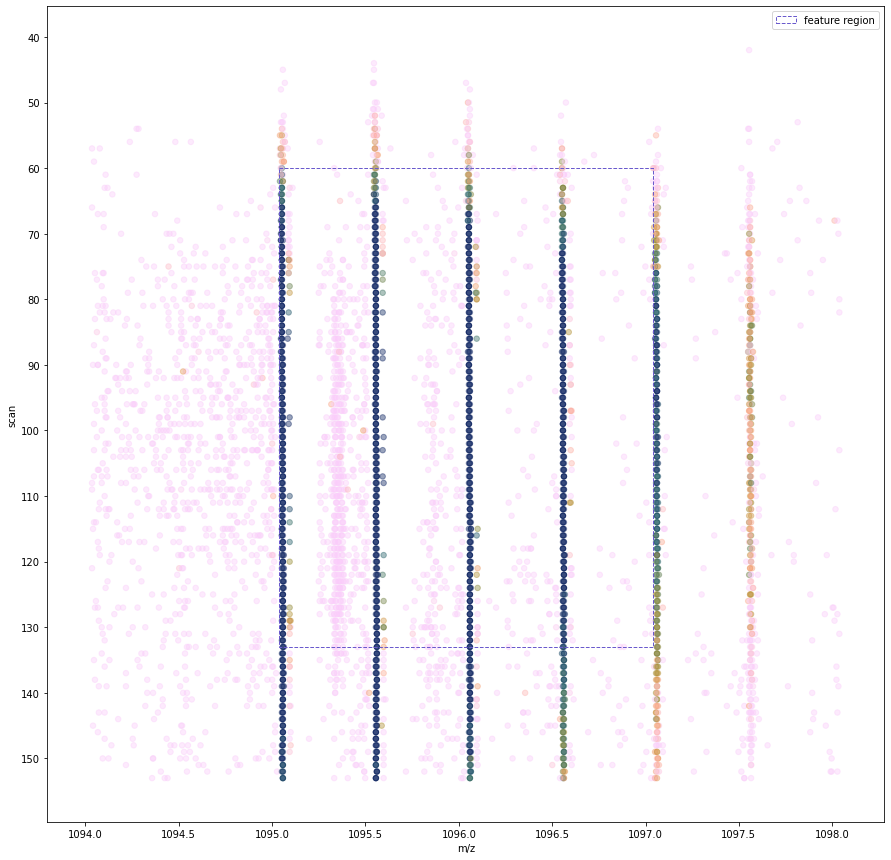

In [57]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(raw_df.mz, raw_df.scan, c=raw_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)

# draw the feature region
top_left = (feature_mz_lower,feature_scan_lower)
width = feature_mz_upper - feature_mz_lower
height = feature_scan_upper - feature_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(raw_df.scan.min() / nearest) * nearest
range_u = round(raw_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

# plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [58]:
raw_df['normalised_intensity'] = raw_df.intensity / raw_df.intensity.max()

In [59]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

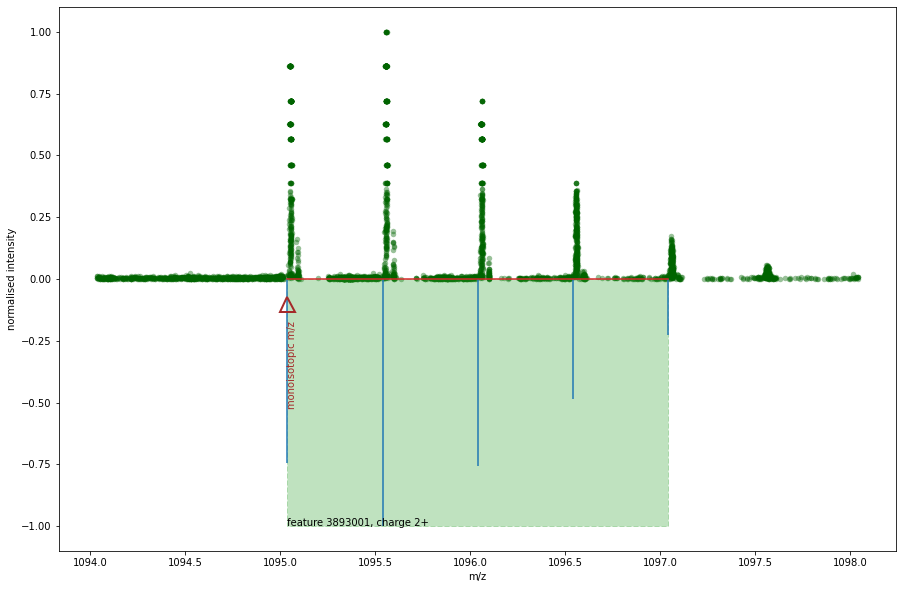

In [60]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

# plot the raw data
ax.scatter(raw_df.mz, raw_df.normalised_intensity, marker='o', color='darkgreen', lw=0, s=30, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(pasef_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(pasef_feature.feature_id, pasef_feature.charge))

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)

# show the monoisotopic m/z determined by deconvolution
ax.plot(pasef_feature.monoisotopic_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(pasef_feature.monoisotopic_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')

# ax.set_title('spectra for feature {}, monoisotopic peak at {} m/z, charge {}+, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), selected_feature.charge, round(selected_feature.deconvolution_score,1)))

plt.show()

### visualise a feature detected by 3DID that crosses a segment boundary

In [61]:
segment_boundary = 820

In [62]:
features_3did_df[(features_3did_df.monoisotopic_mz >= segment_boundary-1) & (features_3did_df.monoisotopic_mz < segment_boundary-0.5)].sort_values(by=['feature_intensity'], ascending=False, inplace=False).head(n=3)

,mono_mz_lower,mono_mz_upper,scan_apex,scan_lower,scan_upper,rt_apex,rt_lower,rt_upper,intensity_without_saturation_correction,intensity_with_saturation_correction,...,feature_region_3d_extent,voxel_id,voxel_metadata_d,scan_df,scan_r_squared,rt_df,rt_r_squared,feature_id,prediction,identification_predicted
26128,819.409790,819.462036,374.0,348.0,400.0,1852.102173,1849.455444,1854.220093,17262,17262,...,"{'mz_lower': 818.446645, 'mz_upper': 822.45, '...",720000186,"{'mz_lower': 819.4, 'mz_upper': 819.5, 'scan_l...","[{'scan': 333, 'intensity': 238, 'filtered_int...",0.997026,"[{'frame_id': 16407, 'retention_time_secs': 18...",0.995346,25568,0.841928,True
22802,819.429810,819.482056,431.0,407.0,455.0,2111.420898,2106.657959,2117.242188,12752,12752,...,"{'mz_lower': 818.446645, 'mz_upper': 822.45, '...",720000187,"{'mz_lower': 819.4, 'mz_upper': 819.5, 'scan_l...","[{'scan': 393, 'intensity': 190, 'filtered_int...",0.991436,"[{'frame_id': 18867, 'retention_time_secs': 21...",0.996979,25569,0.845219,True
26306,819.359741,819.411987,322.0,303.0,345.0,1869.039551,1866.393555,1875.918823,11149,11149,...,"{'mz_lower': 818.346645, 'mz_upper': 822.35, '...",720000136,"{'mz_lower': 819.3000000000001, 'mz_upper': 81...","[{'scan': 299, 'intensity': 72, 'filtered_inte...",0.984933,"[{'frame_id': 16562, 'retention_time_secs': 18...",0.948952,25555,0.841784,True


In [63]:
boundary_3did_feature = features_3did_df.loc[31200]
boundary_3did_feature

mono_mz_lower                                                                    1122.515991
mono_mz_upper                                                                    1122.587524
scan_apex                                                                               98.0
scan_lower                                                                              88.0
scan_upper                                                                             108.0
rt_apex                                                                           2170.69751
rt_lower                                                                         2164.877686
rt_upper                                                                           2172.2854
intensity_without_saturation_correction                                                 2425
intensity_with_saturation_correction                                                    2425
mono_intensity_adjustment_outcome                                 mono

#### feature region at its RT apex

In [64]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)

In [65]:
feature_mz_lower = json.loads(boundary_3did_feature.envelope)[0][0]
feature_mz_upper = json.loads(boundary_3did_feature.envelope)[-1][0]
feature_scan_lower = boundary_3did_feature.scan_lower
feature_scan_upper = boundary_3did_feature.scan_upper
feature_rt_lower = boundary_3did_feature.rt_apex - 1
feature_rt_upper = boundary_3did_feature.rt_apex + 1

In [66]:
mz_lower = feature_mz_lower - 1
mz_upper = feature_mz_upper + 1
scan_lower = feature_scan_lower - 20
scan_upper = feature_scan_upper + 20
rt_lower = feature_rt_lower
rt_upper = feature_rt_upper

In [67]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type == 0 and retention_time_secs >= {} and retention_time_secs <= {} and scan >= {} and scan <= {} and mz >= {} and mz <= {}".format(rt_lower, rt_upper, scan_lower, scan_upper, mz_lower, mz_upper), db_conn)
db_conn.close()

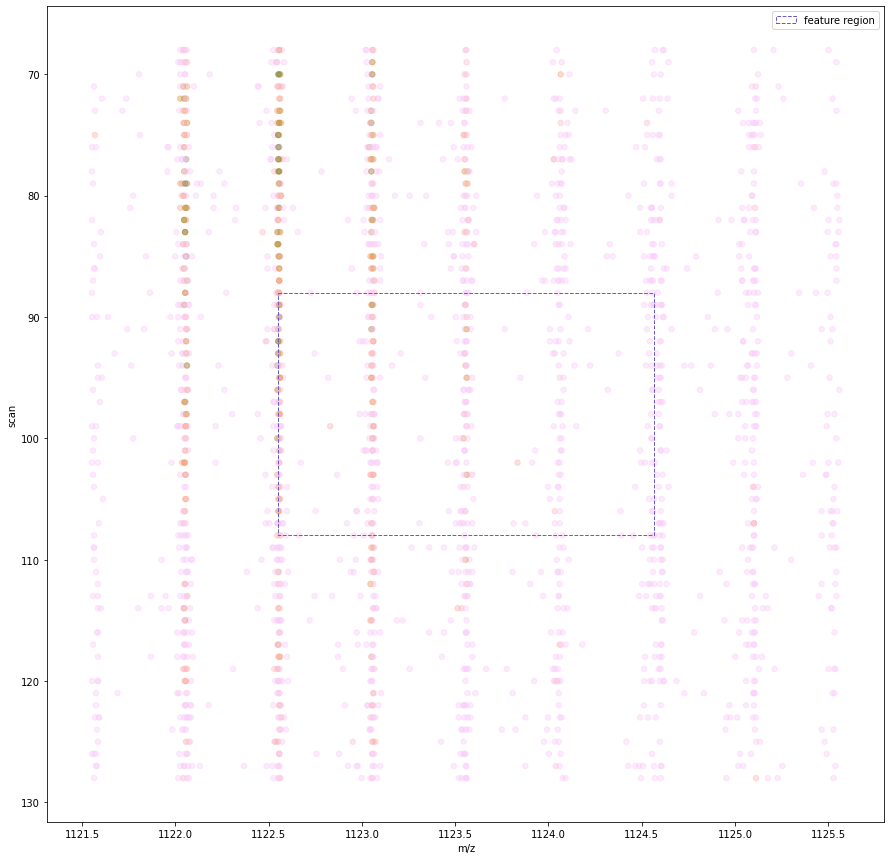

In [68]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(raw_df.mz, raw_df.scan, c=raw_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)

# draw the feature region
top_left = (feature_mz_lower,feature_scan_lower)
width = feature_mz_upper - feature_mz_lower
height = feature_scan_upper - feature_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(raw_df.scan.min() / nearest) * nearest
range_u = round(raw_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

# plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [69]:
raw_df['normalised_intensity'] = raw_df.intensity / raw_df.intensity.max()

In [70]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

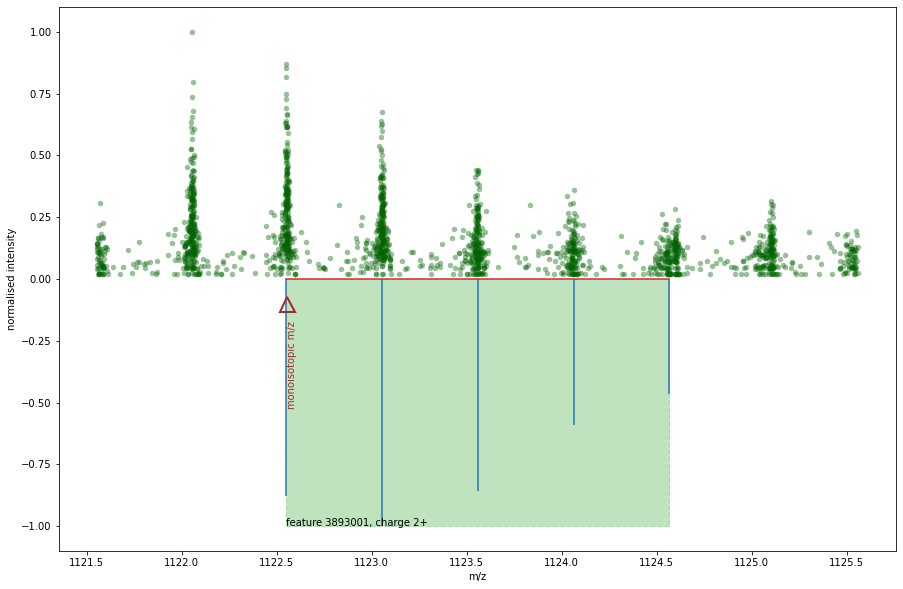

In [71]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

# plot the raw data
ax.scatter(raw_df.mz, raw_df.normalised_intensity, marker='o', color='darkgreen', lw=0, s=30, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(boundary_3did_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(pasef_feature.feature_id, pasef_feature.charge))

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)

# show the monoisotopic m/z determined by deconvolution
ax.plot(boundary_3did_feature.monoisotopic_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(boundary_3did_feature.monoisotopic_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')

# ax.set_title('spectra for feature {}, monoisotopic peak at {} m/z, charge {}+, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), selected_feature.charge, round(selected_feature.deconvolution_score,1)))

plt.show()

### analyse features that were only identified by MaxQuant

In [72]:
combined_id_mq_only = sets_d['mq']-sets_d['3did']-sets_d['pasef']

In [73]:
combined_features_df[(combined_features_df.combined_id.isin(combined_id_mq_only))].sort_values(by=['mq_feature_intensity'], ascending=False, inplace=False).head(n=5)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id,3did_prediction,3did_deconvolution_score,3did_feature_intensity,pasef_deconvolution_score,pasef_feature_intensity,mq_feature_intensity,3did_log_intensity,pasef_log_intensity,mq_log_intensity
5263,5264,1,[mq],[mq-1222822],0,0,1222822,0.790378,246.38414,2723,0.0,0.0,1239400.0,3.435048,0.0,6.093211
4114,4115,1,[mq],[mq-1216140],0,0,1216140,0.790378,246.38414,2723,0.0,0.0,472380.0,3.435048,0.0,5.674292
2325,2326,1,[mq],[mq-1202693],0,0,1202693,0.790378,246.38414,2723,0.0,0.0,362510.0,3.435048,0.0,5.559320
1455,1456,1,[mq],[mq-1192901],0,0,1192901,0.790378,246.38414,2723,0.0,0.0,276000.0,3.435048,0.0,5.440909
3454,3455,1,[mq],[mq-1211685],0,0,1211685,0.790378,246.38414,2723,0.0,0.0,249020.0,3.435048,0.0,5.396234


In [74]:
mq_feature = features_mq_df[(features_mq_df.feature_id == 1192901)].iloc[0]
mq_feature

feature_id                                                     1192901
monoisotopic_mass                                            1599.8105
charge                                                               2
monoisotopic_mz                                              800.91254
intensity                                                       276000
scan_apex                                                          408
scan_lower                                                       352.5
scan_upper                                                       463.5
rt_apex                                                         1788.0
rt_lower                                                       1780.32
rt_upper                                                       1795.68
raw_file                                 P3856_YHE211_1_Slot1-1_1_5104
envelope                          [[800.91254, 0.0], [802.91925, 0.0]]
isotope_count                                                        4
mq_ind

#### isotope extent in retention time

In [75]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
isotope_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type == 0 and retention_time_secs >= {} and retention_time_secs <= {} and scan >= {} and scan <= {} and mz >= {} and mz <= {}".format(mq_feature.rt_lower, mq_feature.rt_upper, mq_feature.scan_lower, mq_feature.scan_upper, mq_feature.monoisotopic_mz-0.1, mq_feature.monoisotopic_mz+0.1), db_conn)
db_conn.close()

In [76]:
len(isotope_points_df)

1957

In [77]:
rt_df = isotope_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_df.sort_values(by=['retention_time_secs'], ascending=True, inplace=True)

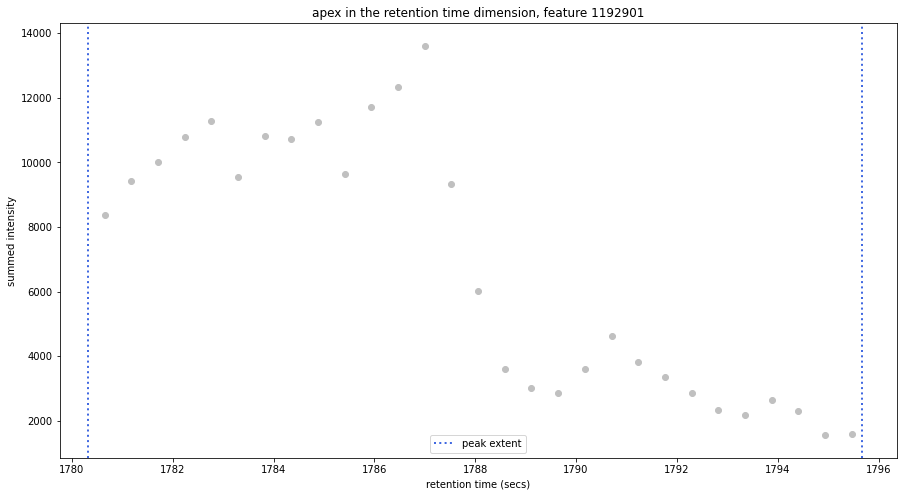

In [78]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver')

# plt.plot(mq_feature.rt_apex, rt_df[rt_df.retention_time_secs==mq_feature.rt_apex].intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=mq_feature.rt_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=mq_feature.rt_upper, linestyle=':', color='royalblue', linewidth=2)

plt.title('apex in the retention time dimension, feature {}'.format(mq_feature.feature_id))
plt.legend()
plt.xlabel("retention time (secs)")
plt.ylabel("summed intensity")
plt.show()

#### isotope extent in mobility

In [79]:
scan_df = pd.DataFrame(pasef_feature.scan_df)

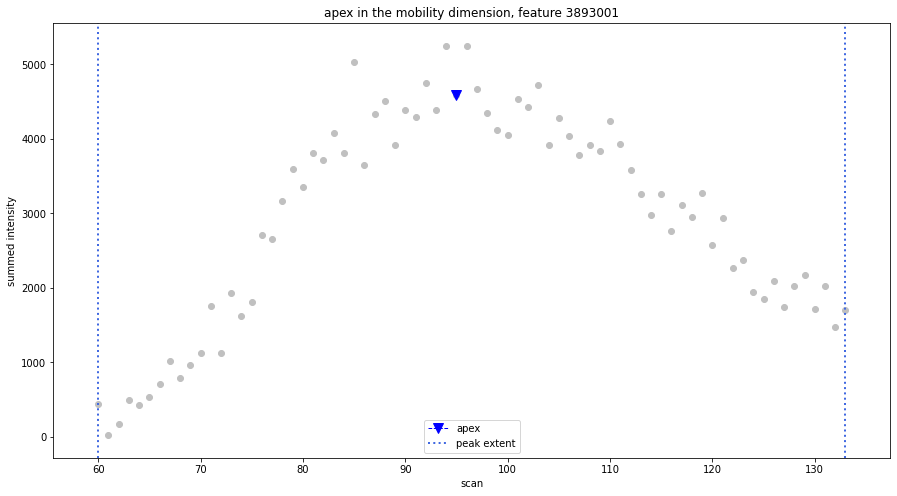

In [80]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_df.scan, scan_df.intensity, c='silver')

plt.plot(pasef_feature.scan_apex, scan_df[scan_df.scan==pasef_feature.scan_apex].intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=pasef_feature.scan_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=pasef_feature.scan_upper, linestyle=':', color='royalblue', linewidth=2)

plt.title('apex in the mobility dimension, feature {}'.format(pasef_feature.feature_id))
plt.legend()
plt.xlabel("scan")
plt.ylabel("summed intensity")
plt.show()

#### feature region at its RT apex

In [81]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)

In [82]:
feature_mz_lower = json.loads(mq_feature.envelope)[0][0]
feature_mz_upper = json.loads(mq_feature.envelope)[-1][0]
feature_scan_lower = mq_feature.scan_lower
feature_scan_upper = mq_feature.scan_upper
feature_rt_lower = mq_feature.rt_apex - 1
feature_rt_upper = mq_feature.rt_apex + 1

In [83]:
mz_lower = feature_mz_lower - 1
mz_upper = feature_mz_upper + 1
scan_lower = feature_scan_lower - 20
scan_upper = feature_scan_upper + 20
rt_lower = feature_rt_lower
rt_upper = feature_rt_upper

In [84]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type == 0 and retention_time_secs >= {} and retention_time_secs <= {} and scan >= {} and scan <= {} and mz >= {} and mz <= {}".format(rt_lower, rt_upper, scan_lower, scan_upper, mz_lower, mz_upper), db_conn)
db_conn.close()

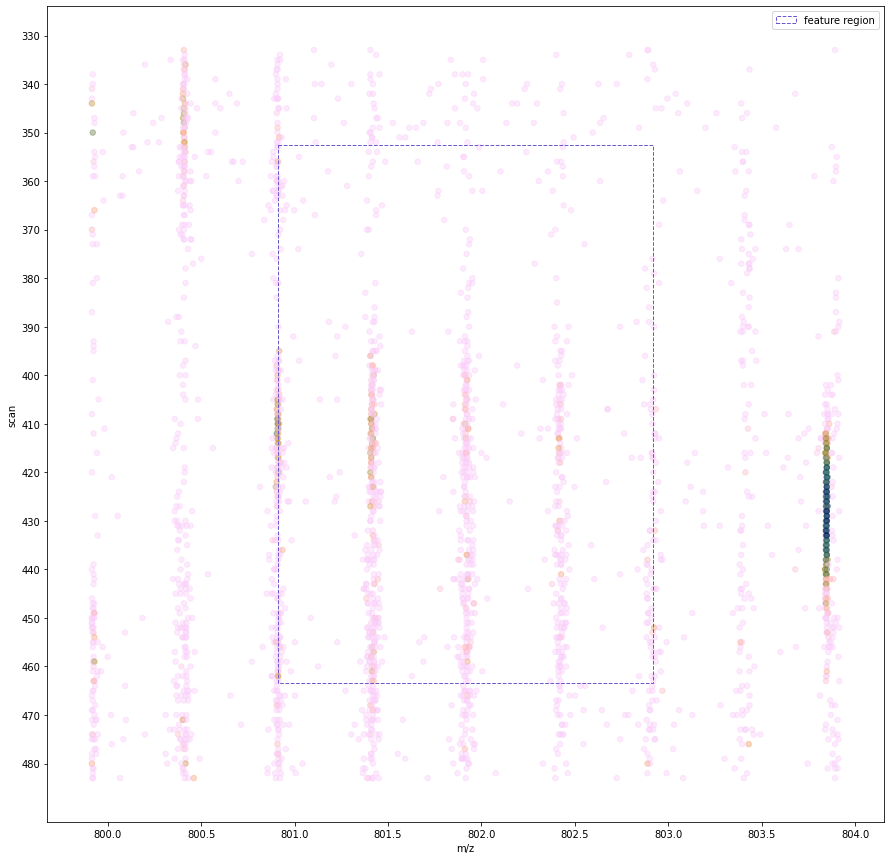

In [85]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(raw_df.mz, raw_df.scan, c=raw_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)

# draw the feature region
top_left = (feature_mz_lower,feature_scan_lower)
width = feature_mz_upper - feature_mz_lower
height = feature_scan_upper - feature_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(raw_df.scan.min() / nearest) * nearest
range_u = round(raw_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

# plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [86]:
raw_df['normalised_intensity'] = raw_df.intensity / raw_df.intensity.max()

In [87]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

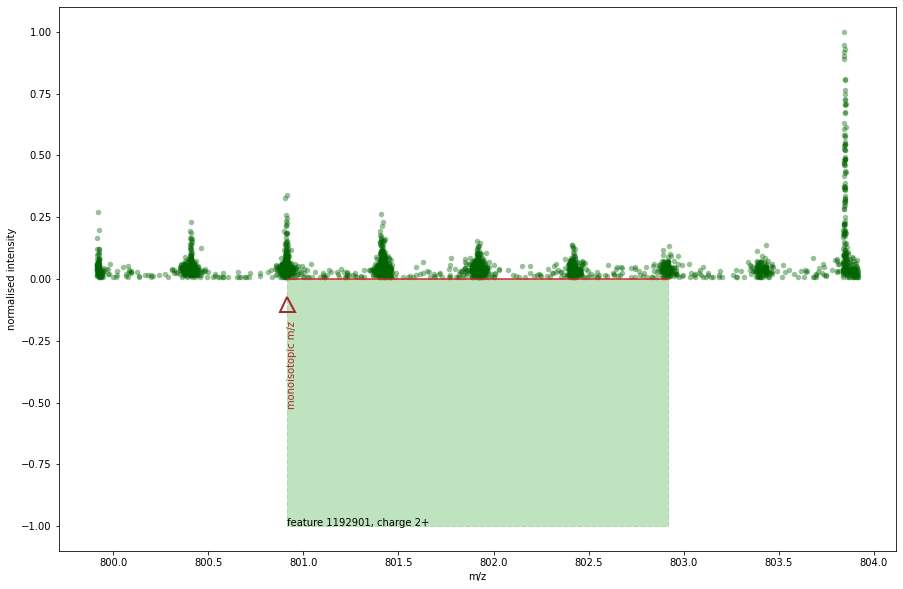

In [88]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

# plot the raw data
ax.scatter(raw_df.mz, raw_df.normalised_intensity, marker='o', color='darkgreen', lw=0, s=30, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(mq_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(mq_feature.feature_id, mq_feature.charge))

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)

# show the monoisotopic m/z determined by deconvolution
ax.plot(mq_feature.monoisotopic_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(mq_feature.monoisotopic_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')

# ax.set_title('spectra for feature {}, monoisotopic peak at {} m/z, charge {}+, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), selected_feature.charge, round(selected_feature.deconvolution_score,1)))

plt.show()

### analyse other attributes of features in common

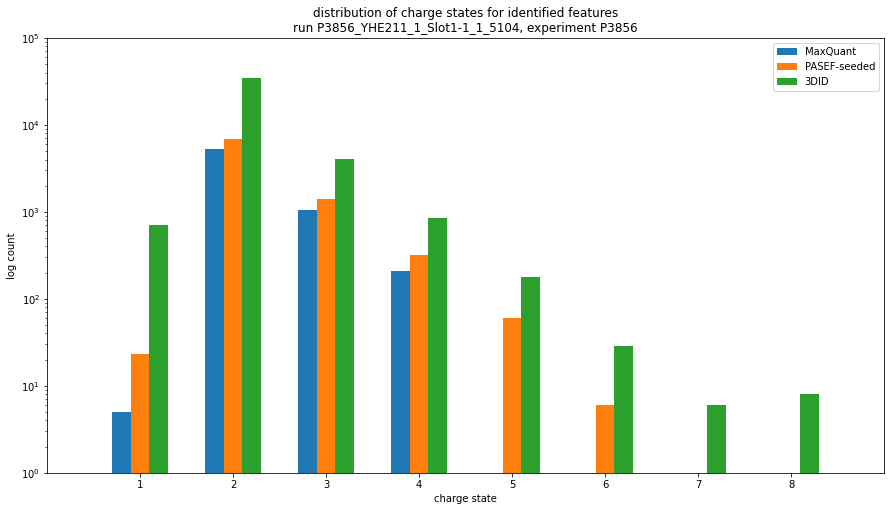

In [89]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

barwidth = 0.2
max_charge = max(idents_mq_df.charge.max(), idents_pasef_df.charge.max(), features_3did_df.charge.max())

pos1 = [x - barwidth for x in range(max_charge+1)]
pos2 = [x + barwidth for x in pos1]
pos3 = [x + (2*barwidth) for x in pos1]

counts = np.bincount(idents_mq_df.charge, minlength=max_charge+1)
ax1.bar(pos1, counts, width=barwidth, align='center', log=True, label='MaxQuant')

counts = np.bincount(idents_pasef_df.charge, minlength=max_charge+1)
ax1.bar(pos2, counts, width=barwidth, align='center', log=True, label='PASEF-seeded')

counts = np.bincount(features_3did_df.charge, minlength=max_charge+1)
ax1.bar(pos3, counts, width=barwidth, align='center', log=True, label='3DID')

ax1.set(xticks=range(1,max_charge+1), xlim=[0, max_charge+1])

plt.xlabel('charge state')
plt.ylabel('log count')
plt.title('distribution of charge states for identified features\nrun {}, experiment {}'.format(run_name, experiment_name))

plt.ylim((1,10**5))

plt.legend()
plt.show()

In [90]:
pasef_3did_df = combined_features_df[(combined_features_df.pasef_feature_id > 0) & (combined_features_df['3did_feature_id'] > 0)]

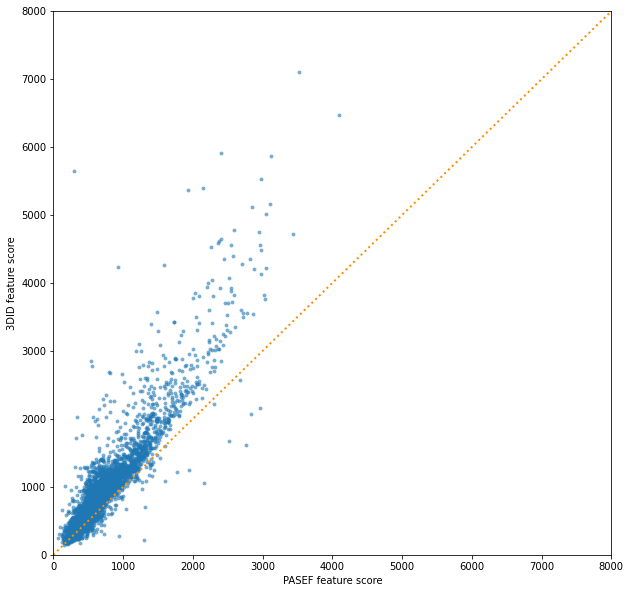

In [91]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
# plt.title('deconvolution score for features identified by PASEF-seeded and features detected by 3DID methods')

ax.scatter(pasef_3did_df.pasef_deconvolution_score, pasef_3did_df['3did_deconvolution_score'], marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-1,8000))
plt.ylim((-1,8000))

plt.xlabel('PASEF feature score')
plt.ylabel('3DID feature score')

plt.show()

In [92]:
combined_features_df = pd.read_pickle('{}/combined_idents_df.pkl'.format(expanduser('~')))

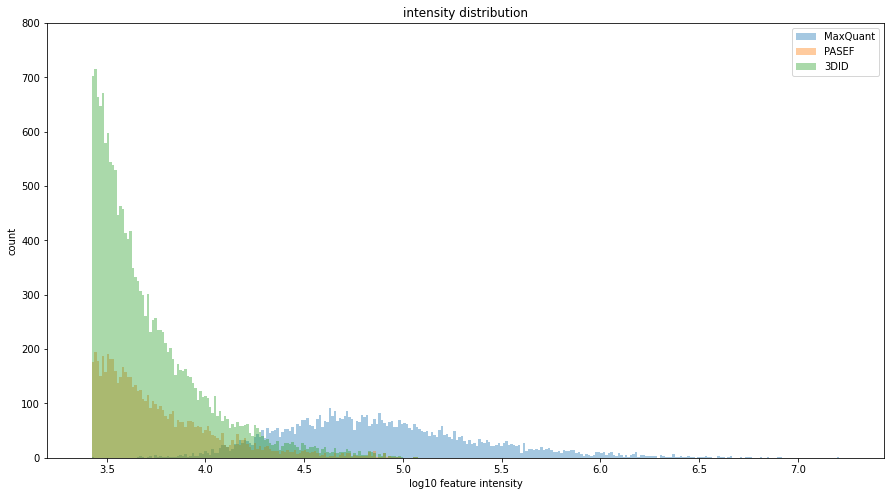

In [93]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity distribution')

bins = 300
hist, bins, _ = plt.hist(combined_features_df[combined_features_df.mq_feature_id > 0].mq_log_intensity, bins=bins, alpha=0.4, label='MaxQuant')
hist, bins, _ = plt.hist(combined_features_df[combined_features_df.pasef_feature_id > 0].pasef_log_intensity, bins=bins, alpha=0.4, label='PASEF')
hist, bins, _ = plt.hist(combined_features_df[combined_features_df['3did_feature_id'] > 0]['3did_log_intensity'], bins=bins, alpha=0.4, label='3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((0,8))
plt.ylim((0,800))

plt.legend()
plt.show()

In [94]:
unique_mq_df = combined_features_df[(combined_features_df.mq_feature_id > 0) & (combined_features_df.pasef_feature_id == 0) & (combined_features_df['3did_feature_id'] == 0)]
unique_pasef_df = combined_features_df[(combined_features_df.mq_feature_id == 0) & (combined_features_df.pasef_feature_id > 0) & (combined_features_df['3did_feature_id'] == 0)]
unique_3did_df = combined_features_df[(combined_features_df.mq_feature_id == 0) & (combined_features_df.pasef_feature_id == 0) & (combined_features_df['3did_feature_id'] > 0)]


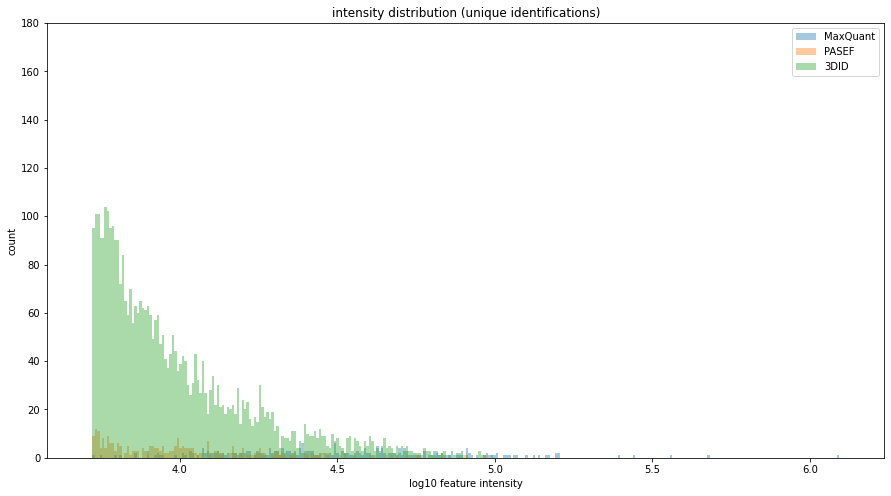

In [95]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity distribution (unique identifications)')

bins = 300
hist, bins, _ = plt.hist(unique_mq_df.mq_log_intensity, bins=bins, alpha=0.4, label='MaxQuant')
hist, bins, _ = plt.hist(unique_pasef_df.pasef_log_intensity, bins=bins, alpha=0.4, label='PASEF')
hist, bins, _ = plt.hist(unique_3did_df['3did_log_intensity'], bins=bins, alpha=0.4, label='3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((0,8))
plt.ylim((0,180))

plt.legend()
plt.show()

### distribution of MaxQuant identified features also identified by 3DID

In [96]:
all_mq_df = combined_features_df[(combined_features_df.mq_feature_id > 0)]
all_mq_common_3did_df = combined_features_df[(combined_features_df.mq_feature_id > 0) & (combined_features_df['3did_feature_id'] > 0)]

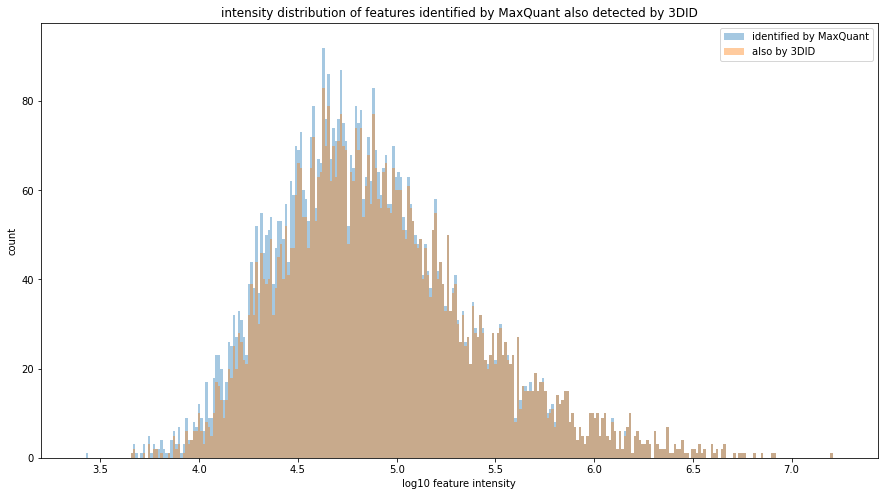

In [97]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity distribution of features identified by MaxQuant also detected by 3DID')

bins = 300
hist, bins, _ = plt.hist(all_mq_df.mq_log_intensity, bins=bins, alpha=0.4, label='identified by MaxQuant')
hist, bins, _ = plt.hist(all_mq_common_3did_df.mq_log_intensity, bins=bins, alpha=0.4, label='also by 3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((0,8))
# plt.ylim((0,800))

plt.legend()
plt.show()

#### is there a linear scaling factor between 3DID and MaxQuant intensity?

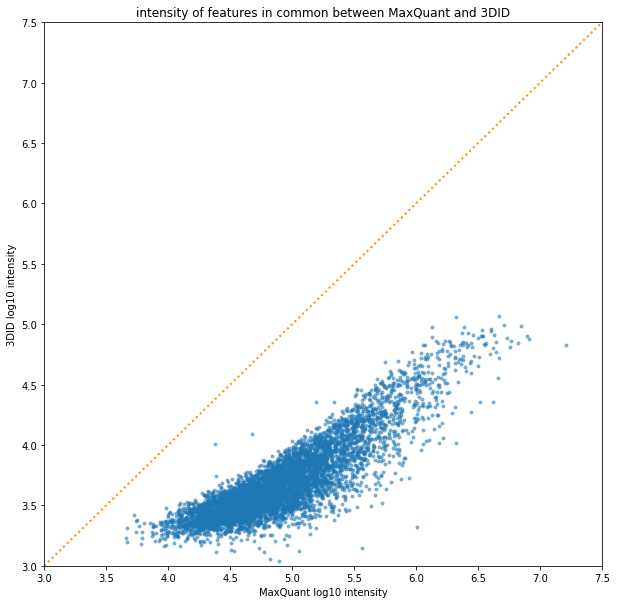

In [98]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('intensity of features in common between MaxQuant and 3DID')

ax.scatter(all_mq_common_3did_df.mq_log_intensity, all_mq_common_3did_df['3did_log_intensity'], marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((3.0,7.5))
plt.ylim((3.0,7.5))

plt.xlabel('MaxQuant log10 intensity')
plt.ylabel('3DID log10 intensity')

plt.show()

### compare 3did _identified_ features for different minvi

In [99]:
MINVI_LOW = 3000
MINVI_HIGH = 5000

In [100]:
FEATURES_3DID_MINVI_LOW_DIR = sorted(glob.glob('/media/big-ssd/results-P3856-3did/minvi-{}-*/features-3did'.format(MINVI_LOW)))[-1]
FEATURES_3DID_MINVI_LOW_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

FEATURES_3DID_MINVI_HIGH_DIR = sorted(glob.glob('/media/big-ssd/results-P3856-3did/minvi-{}-*/features-3did'.format(MINVI_HIGH)))[-1]
FEATURES_3DID_MINVI_HIGH_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

In [101]:
# load the features detected by 3DID
with open(FEATURES_3DID_MINVI_HIGH_FILE, 'rb') as handle:
    d = pickle.load(handle)
minvi_high_idents_df = d['features_df']

In [102]:
# load the features detected by 3DID
with open(FEATURES_3DID_MINVI_LOW_FILE, 'rb') as handle:
    d = pickle.load(handle)
minvi_low_idents_df = d['features_df']

In [103]:
minvi_high_idents_df = minvi_high_idents_df[combined_names].copy()
minvi_high_idents_df['minvi'] = str(MINVI_HIGH)

minvi_low_idents_df = minvi_low_idents_df[combined_names].copy()
minvi_low_idents_df['minvi'] = str(MINVI_LOW)

minvi_idents_df = pd.concat([minvi_low_idents_df,minvi_high_idents_df], axis=0, sort=False, ignore_index=True)
minvi_idents_df['minvi_feature_id'] = minvi_idents_df.minvi+'-'+minvi_idents_df.feature_id.astype('str')

In [104]:
len(minvi_high_idents_df), len(minvi_low_idents_df)

(31772, 50051)

In [105]:
minvi_idents_df.sample(n=5)

,feature_id,charge,monoisotopic_mz,scan_apex,rt_apex,minvi,minvi_feature_id
3203,103281,1,1018.503296,81.0,1654.148315,3000,3000-103281
42820,58184,2,862.375093,396.0,1738.304688,3000,3000-58184
34559,112137,2,1041.988833,103.0,1678.494141,3000,3000-112137
68487,32271,2,917.458833,355.0,1679.552124,5000,5000-32271
60676,44059,2,991.985107,221.0,2084.424316,5000,5000-44059


#### find the identifications in common between the different minvi values

In [106]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
minvi_idents_df['dup_mz'] = minvi_idents_df['monoisotopic_mz']  # shorthand to reduce verbosity
minvi_idents_df['dup_mz_ppm_tolerance'] = minvi_idents_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
minvi_idents_df['dup_mz_lower'] = minvi_idents_df.dup_mz - minvi_idents_df.dup_mz_ppm_tolerance
minvi_idents_df['dup_mz_upper'] = minvi_idents_df.dup_mz + minvi_idents_df.dup_mz_ppm_tolerance
minvi_idents_df['dup_scan_lower'] = minvi_idents_df.scan_apex - DUP_SCAN_TOLERANCE
minvi_idents_df['dup_scan_upper'] = minvi_idents_df.scan_apex + DUP_SCAN_TOLERANCE
minvi_idents_df['dup_rt_lower'] = minvi_idents_df.rt_apex - DUP_RT_TOLERANCE
minvi_idents_df['dup_rt_upper'] = minvi_idents_df.rt_apex + DUP_RT_TOLERANCE

In [107]:
combined_id = 1
combined_features = []
sets_d = {str(MINVI_HIGH):set(), str(MINVI_LOW):set()}
features_processed = set()
for row in minvi_idents_df.itertuples():
    if row.minvi_feature_id not in features_processed:
        df = minvi_idents_df[(row.charge == minvi_idents_df.charge) & (row.dup_mz >= minvi_idents_df.dup_mz_lower) & (row.dup_mz <= minvi_idents_df.dup_mz_upper) & (row.scan_apex >= minvi_idents_df.dup_scan_lower) & (row.scan_apex <= minvi_idents_df.dup_scan_upper) & (row.rt_apex >= minvi_idents_df.dup_rt_lower) & (row.rt_apex <= minvi_idents_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.minvi_feature_id.tolist()) - features_processed
            df = df[(df.minvi_feature_id.isin(feature_ids_not_processed))]
            for minvi in df.minvi.tolist():
                sets_d[minvi].add(combined_id)
            # record the features that have been processed
            features_processed.update(set(df.minvi_feature_id.tolist()))
            # separate the minvi feature ids
            feature_ids = {str(MINVI_HIGH):0, str(MINVI_LOW):0}
            for m in df.minvi_feature_id.tolist():
                minvi = m.split('-')[0]
                feature_id = int(m.split('-')[1])
                feature_ids[minvi] = feature_id
            # store the features that were combined
            combined_features.append({'combined_id':combined_id, 'number_of_minvis':len(df.minvi.unique()), 'minvis':list(df.minvi.unique()), 'minvi_ids':df.minvi_feature_id.tolist(), 'minvi_5000_feature_id':feature_ids['5000'], 'minvi_3000_feature_id':feature_ids['3000']})
            # update the combined feature identifier
            combined_id += 1

In [108]:
combined_features_df = pd.DataFrame(combined_features)
combined_features_df.to_pickle('{}/combined_features_minvi_df.pkl'.format(expanduser('~')))

In [109]:
combined_features_df.sample(n=5)

,combined_id,number_of_minvis,minvis,minvi_ids,minvi_5000_feature_id,minvi_3000_feature_id
47331,47332,1,[3000],[3000-20593],0,20593
13984,13985,2,"[3000, 5000]","[3000-90114, 5000-39992]",39992,90114
31908,31909,1,[3000],[3000-117478],0,117478
20326,20327,2,"[3000, 5000]","[3000-111733, 5000-49734]",49734,111733
22143,22144,2,"[3000, 5000]","[3000-125771, 5000-55311]",55311,125771


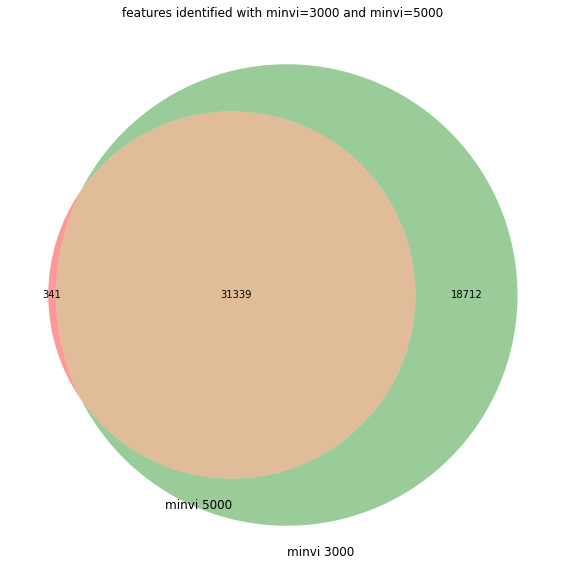

In [110]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features identified with minvi={} and minvi={}'.format(MINVI_LOW,MINVI_HIGH))

venn2([sets_d[str(MINVI_HIGH)],sets_d[str(MINVI_LOW)]], ('minvi {}'.format(MINVI_HIGH),'minvi {}'.format(MINVI_LOW)))

plt.show()